In [1]:
from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from astropy.stats import LombScargle
%matplotlib inline
plt.style.use('seaborn')
# in order to use custom modules in parent path
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from mfilter.implementations.simulate import SimulateSignal
from mfilter.types.arrays import Array
from mfilter.types.frequencyseries import FrequencySamples
from mfilter.implementations.regressions import *

$$ \int_{-\infty}^{\infty} \frac{\tilde{x}(f)\tilde{h}(f)}{S_n(f)} e^{2\pi i f t_0} df$$

0.1
0.2
ratio E.signal/E.noise:  38.42196178848467


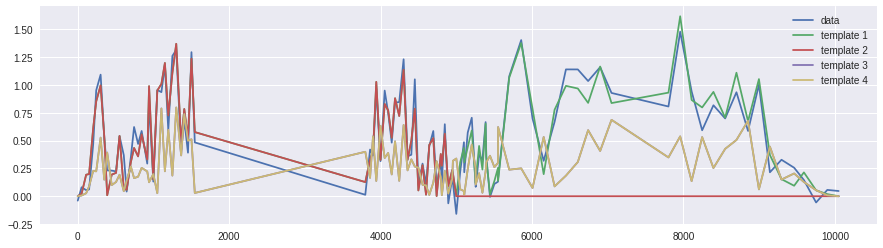

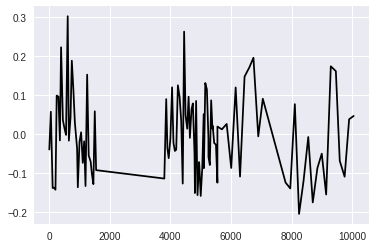

In [145]:
n_samples = 100
freq = [0.0001, 0.001, 0.01, 0.1]
weights=[1, 0.4, 0.4, 0.4]
config="mix1"
pos_start_peaks = 0
n_peaks = 1
simulated = SimulateSignal(n_samples, freq, weights=weights, noise_level=0.1,
                           dwindow="tukey", underlying_delta=50)

weights2= np.array(weights) / 2 
simulated2 = SimulateSignal(n_samples, freq, weights=weights2, noise_level=0.2,
                           dwindow="tukey", underlying_delta=50)

times = simulated.get_times(configuration=config)
# data = simulated.get_data(pos_start_peaks=pos_start_peaks, n_peaks=n_peaks,
#                           with_noise=True,
#                           configuration=config)
noise = simulated.get_noise(None)
temp = simulated.get_data(pos_start_peaks=0, n_peaks=2, with_noise=False,
                          configuration=config)
temp = abs(temp)
temp2 = simulated.get_data(pos_start_peaks=0, n_peaks=0.5,
                           configuration=config)
temp2 = abs(temp2)
temp3 = simulated2.get_data(pos_start_peaks=0, n_peaks=1, with_noise=False,
                          configuration=config)
temp3 = abs(temp3)
temp4 = simulated2.get_data(pos_start_peaks=0, n_peaks=1.5, with_noise=False,
                          configuration=config)
temp4 = abs(temp4)

data = temp + noise
# templates with same energy (any value, here we take the energy of the data)
E = np.sum(data**2)
E_n = np.sum(noise**2)
print("ratio E.signal/E.noise: ", E/E_n)
# E = E_n
#temp *= E / np.sum(temp**2)
#temp2 *= E / np.sum(temp2**2)


plt.figure(figsize=(15, 4))
plt.plot(times, data, label='data')
plt.plot(times, temp, label='template 1')
plt.plot(times, temp2, label='template 2')
plt.plot(times, temp3, label='template 3')
plt.plot(times, temp4, label='template 4')
plt.legend()

plt.figure()
plt.plot(times, noise, 'k', label="noise")


sampling rate is:  0.0099601593625498
2013 100


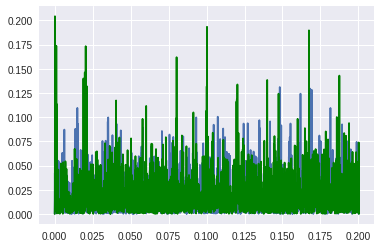

In [130]:
samples_per_peak = 5
T = max(times) - min(times)
fs = n_samples / T
print("sampling rate is: ", (n_samples / T))
df = 1 / T / samples_per_peak
max_freq = 2 * max(freq) + 20 * df

freqs = FrequencySamples(Array(times),
                        minimum_frequency=0,
                        maximum_frequency=max_freq)
def lomb_psd(values, freqs, times):
    lomb = LombScargle(times, values, normalization="standard")

    if freqs.has_zero:
        zero_idx = freqs.zero_idx
        psd = np.zeros(len(freqs))
        if zero_idx == 0:
            psd[1:] = lomb.power(freqs.data[1:])
            psd[0] = 0.0000001
        else:
            neg_freq, pos_freq = freqs.split_by_zero()
            right_psd = lomb.power(pos_freq)
            left_psd = lomb.power(np.abs(neg_freq))
            psd[:zero_idx] = left_psd
            psd[zero_idx] = 0.000001
            psd[zero_idx+1:] = right_psd
    else:
        psd = lomb.power(np.abs(freqs.data))
    return psd
psd = lomb_psd(noise, freqs, times)
psd_data = lomb_psd(data, freqs, times)
print(len(freqs), len(times))
plt.figure()
plt.plot(freqs.data, psd)
plt.plot(freqs.data, psd_data, 'g')
# plt.xlim([0, 0.2])
# plt.ylim([0, 0.02])

In [104]:
# say that my psd of noise is the square of the ft of the noise
#psd = (abs(noise_ft)**2) 
#print(np.where(psd == 0.0))
#psd[0] = 0.000000001

lambda is:  50200.0 0.004463218426774518


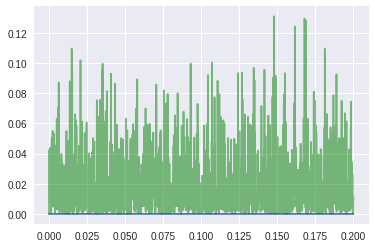

In [131]:
reg = ElasticNetRegression(alpha=0.001, l1_ratio=0.7)
reg = RidgeRegression(alpha=0.01)
F = Dictionary(times, freqs)

data_ft = reg.get_ft(data, F)
temp_ft = reg.get_ft(temp, F)
temp2_ft = reg.get_ft(temp2, F)
temp3_ft = reg.get_ft(temp3, F)
temp4_ft = reg.get_ft(temp4, F)
noise_ft = reg.get_ft(noise, F)

plt.plot(freqs.data, abs(noise_ft)**2)
plt.plot(freqs.data, psd , 'g', alpha=0.5)
print("lambda is: ", np.sqrt(1 / df**2), np.sqrt(df))

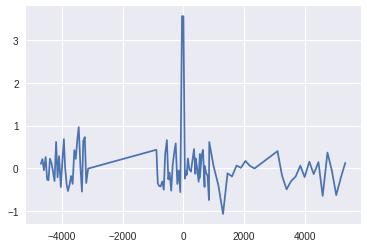

In [132]:
def get_z(ft, temp_ft, psd, F):
    corr = ft.conjugate() * temp_ft / psd
    return np.dot(F.matrix, corr).real

z_data = get_z(data_ft, temp_ft, psd, F)
z_data2 = get_z(data_ft, temp2_ft, psd, F)
z_data3 = get_z(data_ft, temp3_ft, psd, F)
z_data4 = get_z(data_ft, temp4_ft, psd, F)
z_noise = get_z(noise_ft, temp_ft, psd, F)
z_noise2 = get_z(noise_ft, temp2_ft, psd, F)
z_noise3 = get_z(noise_ft, temp3_ft, psd, F)
z_noise4 = get_z(noise_ft, temp4_ft, psd, F)
plt.plot(times - times[n_samples//2], np.roll(z_data, n_samples//2))
# plt.plot(times - times[n_samples//2], np.roll(noise, n_samples//2), 'r', alpha=0.4)
# plt.plot(times - times[n_samples//2], np.random.normal(0, 0.05, n_samples), 'g', alpha=0.5)

var is  (3.5605618036321416+0j) (2.493665818633765+0j) (0.6510931834635784+0j) (0.6510931834635784+0j)


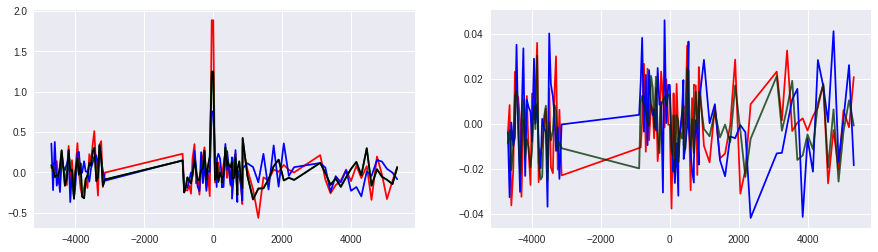

In [133]:
def get_sigma(temp_ft, psd):
    return np.sum(temp_ft * temp_ft.conjugate() / psd)

sigma_temp = get_sigma(temp_ft, psd)
sigma2_temp = get_sigma(temp2_ft, psd)
sigma3_temp = get_sigma(temp3_ft, psd)
sigma4_temp = get_sigma(temp4_ft, psd)

print("var is ", sigma_temp, sigma2_temp, sigma3_temp, sigma4_temp)

snr_data = z_data / np.sqrt(sigma_temp.real)
snr_data2 = z_data2 / np.sqrt(sigma2_temp.real)
snr_data3 = z_data3 / np.sqrt(sigma3_temp.real)
snr_data4 = z_data4 / np.sqrt(sigma4_temp.real)

snr_noise = z_noise / np.sqrt(sigma_temp.real)
snr_noise2 = z_noise2 / np.sqrt(sigma2_temp.real)
snr_noise3 = z_noise3 / np.sqrt(sigma3_temp.real)
snr_noise4 = z_noise4 / np.sqrt(sigma4_temp.real)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15,4))
ax1.plot(times - times[n_samples//2], np.roll(snr_data, n_samples//2), 'r')
ax1.plot(times - times[n_samples//2], np.roll(snr_data2, n_samples//2), 'b')
ax1.plot(times - times[n_samples//2], np.roll(snr_data3, n_samples//2), 'g')
ax1.plot(times - times[n_samples//2], np.roll(snr_data4, n_samples//2), 'k')

ax2.plot(times - times[n_samples//2], np.roll(snr_noise, n_samples//2), 'r')
ax2.plot(times - times[n_samples//2], np.roll(snr_noise2, n_samples//2), 'b')
ax2.plot(times - times[n_samples//2], np.roll(snr_noise3, n_samples//2), 'g', alpha=0.5)
ax2.plot(times - times[n_samples//2], np.roll(snr_noise4, n_samples//2), 'k', alpha=0.5)


In [122]:
np.sum(data_ft.conjugate() * temp_ft / psd) / np.sqrt(sigma_temp)

(6.589076426967543+0.4253070774060145j)

In [134]:
lomb = LombScargle(times, snr_data2, normalization="standard")
if freq.has_zero:
    zero_idx = freq.zero_idx
    neg_freq, pos_freq = freq.split_by_zero()
    right_psd = lomb.power(pos_freq)
    left_psd = lomb.power(np.abs(neg_freq))

    psd_z = np.zeros(len(freq))
    psd_z[:zero_idx] = left_psd
    psd_z[zero_idx] = 0.000001
    psd_z[zero_idx+1:] = right_psd
else:
    psd_z = lomb.power(np.abs(freq.data))

AttributeError: 'list' object has no attribute 'has_zero'

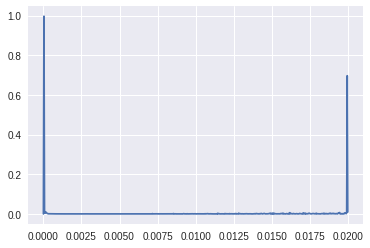

In [387]:
plt.plot(freq.data, psd_z)

In [135]:
norm = sp.stats.norm(0, (sigma_temp.real)**(1/2))
print("for only noise: ", (1 - norm.cdf(max(snr_noise))))
print("for data: ", (1 - norm.cdf(max(snr_data))))

norm = sp.stats.norm(0, (sigma2_temp.real)**(1/2))
print("for only noise: ", (1 - norm.cdf(max(snr_noise2))))
print("for data: ", (1 - norm.cdf(max(snr_data2))))

norm = sp.stats.norm(0, (sigma3_temp.real)**(1/2))
print("for only noise: ", (1 - norm.cdf(max(snr_noise3))))
print("for data: ", (1 - norm.cdf(max(snr_data3))))

norm = sp.stats.norm(0, (sigma4_temp.real)**(1/2))
print("for only noise: ", (1 - norm.cdf(max(snr_noise4))))
print("for data: ", (1 - norm.cdf(max(snr_data4))))

# or using same sigma as the original noise
norm = sp.stats.norm(0, 0.)

for only noise:  0.4923816841959593
for data:  0.1587003234314608
for only noise:  0.48835598576058337
for data:  0.3163645750611993
for only noise:  0.48501142581925627
for data:  0.06079144249282509
for only noise:  0.48501142581925627
for data:  0.06079144249282509


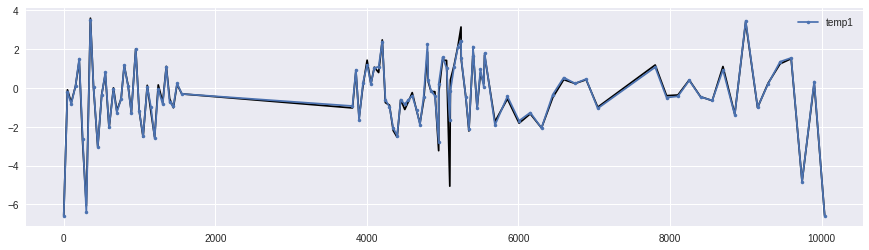

In [144]:
plt.figure(figsize=(15, 4))
plt.plot(times, np.dot(F.matrix, data_ft / np.sqrt(psd)).real, 'k')
plt.plot(times, np.roll(np.dot(F.matrix, temp_ft / np.sqrt(psd)).real, snr_data.argmax() + 1), '.-', label="temp1")
# plt.plot(times, np.roll(np.dot(F.matrix, temp2_ft / np.sqrt(psd)).real, snr_data2.argmax() + 1), 'o--', label="temp2")
# plt.plot(times, np.roll(np.dot(F.matrix, temp3_ft / np.sqrt(psd)).real, snr_data3.argmax()+1), label="temp3")
# plt.plot(times, np.roll(np.dot(F.matrix, temp4_ft / np.sqrt(psd)).real, snr_data4.argmax()+1), label="temp4")
plt.legend()

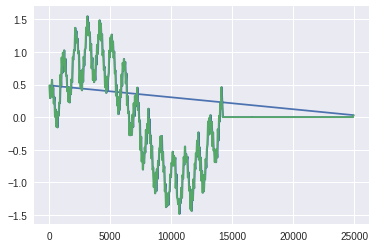

In [307]:
plt.plot((times +  times[n_samples//3] + times[snr_data.argmax()]) % max(times), temp)
plt.plot(times, np.roll(temp, n_samples//3 + snr_data.argmax()))

In [299]:
max(times)

24956

In [208]:
norm.stats()

(array(-0.88142214), array(4.67692286))

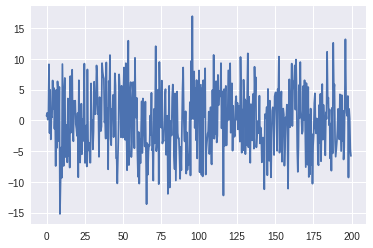

In [20]:
nn = np.random.normal(0, 5, 500)
dtt = 0.4
tt = np.arange(500) * dtt 
plt.plot(tt, nn)

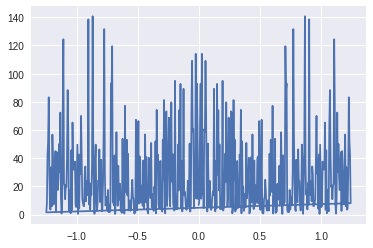

In [44]:
nn_ft = sp.fft(nn)
freq = np.fft.fftfreq(500, d=dtt)
f, nn_psd = sp.signal.welch(nn, 1/dtt, return_onesided=False, nfft=500)
plt.plot(freq, np.abs(nn_ft)**2 / 500)

/home/pancho/.local/lib/python3.5/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


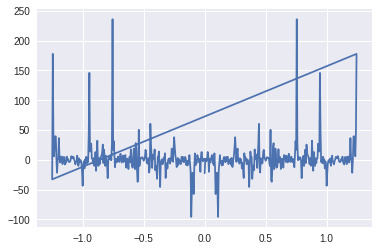

In [45]:
plt.plot(f, nn_ft / nn_psd)

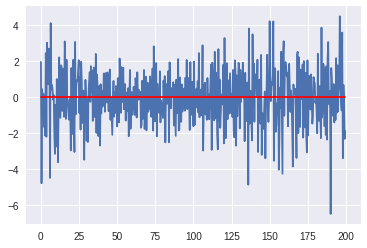

In [46]:
nn_r = np.fft.ifft(nn_ft / nn_psd)
plt.plot(tt, nn_r.real)
plt.plot(tt, nn_r.imag, 'r')

In [48]:
print(np.std(nn_r.real), np.std(nn))

1.591111241365638 5.295939177543416
